In [11]:
import os
import json
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from catboost import CatBoostRegressor

# Displaying pd Dataframe options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)

In [12]:
%%time
# Get datas from pickle
train_df = pd.read_pickle('train_df.pickle')
test_df = pd.read_pickle('test_df.pickle')
test_df['transactionRevenue'] = np.nan

full_df = pd.concat([train_df, test_df], axis=0)

full_df['date'] = pd.to_datetime(full_df['date'], format='%Y%m%d')
full_df['weekday'] = full_df['date'].dt.weekday_name
full_df['day_off'] = (full_df['date'].dt.dayofweek > 4).astype(int)



CPU times: user 8.06 s, sys: 6.99 s, total: 15.1 s
Wall time: 16.3 s


In [13]:
count_user_by_visits = {}
def check_count_by_visits(Id):
    if Id in count_user_by_visits:
        count_user_by_visits[Id]+= 1
    else:
        count_user_by_visits[Id]= 1
    
    return count_user_by_visits[Id]

full_df['visit_index'] = [check_count_by_visits(user) for user in full_df['fullVisitorId']]

In [18]:
cat_features = ['channelGrouping','isMobile','browser','deviceCategory','operatingSystem',
               'country','region','subContinent','networkDomain','continent','newVisits',
               'medium', 'isTrueDirect', 'source', 'isVideoAd', 'slot','page', 'day_off', 
                'weekday']
num_features = ['visitNumber','pageviews','hits', 'visit_index']

In [22]:
full_df[num_features] = full_df[num_features].replace('no_key', 0).fillna(0)
full_df[cat_features] = full_df[cat_features].fillna('other')

In [23]:
X_train, X_test = full_df[full_df['transactionRevenue'] >= 0], full_df[~(full_df['transactionRevenue'] >= 0)]
y_train = X_train['transactionRevenue']

X_train, X_test = X_train[cat_features+num_features], X_test[['fullVisitorId']+cat_features+num_features]

In [24]:
categorical_features=[i for i, x in enumerate(X_train.columns) if x in cat_features]

In [28]:
# 13) Интегрировать код в блок с обучением катбуста. Для снижения снижения лернрейта
def down_iter(size):
    if size == 1:
        return [1]
    if size == 2:
        return [0.5,0.5]
    
    prev_arr = down_iter(size-1)[:-1]
    next_value = (1 - sum(prev_arr)) / 2
    return prev_arr + [next_value] * 2

def train_catboost(model, X, y, cat_features, lr_down_rate=5):
    iterations = model.get_params()['iterations']
    learning_rate = model.get_params()['learning_rate']
    bounds = np.array(down_iter(lr_down_rate))
    lr_arr = [learning_rate / (1.9 ** i) for i in range(lr_down_rate)]
    iter_arr = (bounds * iterations).astype(int) 
    n_trees_count = 0
    for n_trees, lr in zip(iter_arr, lr_arr):
        n_trees_count += n_trees
        print(n_trees, lr)
        model.set_params(iterations=n_trees_count, learning_rate=lr)
        model.fit(X, y, cat_features=[i for i, c in enumerate(X) if c in cat_features])
    return model

In [29]:
model_Cat = CatBoostRegressor(iterations=1300, thread_count=4, learning_rate=0.4,
                             depth=7, border_count=100, has_time=True,
                             counter_calc_method='SkipTest')

# train_catboost(model_Cat, X_train, y_train, cat_features=categorical_features) 
# Падает на ошибке ValueError: Cannot convert 'b'Direct'' to float

model_Cat.fit(X_train, y_train, cat_features=categorical_features)

0:	learn: 1.8182406	total: 2.38s	remaining: 51m 33s
1:	learn: 1.7377043	total: 4.71s	remaining: 50m 53s
2:	learn: 1.6961360	total: 6.98s	remaining: 50m 18s
3:	learn: 1.6768457	total: 9.25s	remaining: 49m 57s
4:	learn: 1.6651041	total: 11.4s	remaining: 49m 7s
5:	learn: 1.6575650	total: 13.6s	remaining: 48m 57s
6:	learn: 1.6535478	total: 15.7s	remaining: 48m 25s
7:	learn: 1.6482470	total: 17.9s	remaining: 48m 13s
8:	learn: 1.6450716	total: 20.2s	remaining: 48m 14s
9:	learn: 1.6427740	total: 22.5s	remaining: 48m 20s
10:	learn: 1.6409213	total: 24.4s	remaining: 47m 41s
11:	learn: 1.6380342	total: 26.3s	remaining: 47m 4s
12:	learn: 1.6339311	total: 28.4s	remaining: 46m 49s
13:	learn: 1.6322336	total: 30.5s	remaining: 46m 42s
14:	learn: 1.6313100	total: 32.9s	remaining: 46m 54s
15:	learn: 1.6281060	total: 35s	remaining: 46m 44s
16:	learn: 1.6272030	total: 37.1s	remaining: 46m 37s
17:	learn: 1.6256457	total: 39.3s	remaining: 46m 42s
18:	learn: 1.6241212	total: 41.3s	remaining: 46m 21s
19:	lea

153:	learn: 1.5398328	total: 5m 31s	remaining: 41m 6s
154:	learn: 1.5395903	total: 5m 33s	remaining: 41m 4s
155:	learn: 1.5388129	total: 5m 35s	remaining: 41m 1s
156:	learn: 1.5380218	total: 5m 37s	remaining: 40m 59s
157:	learn: 1.5369187	total: 5m 40s	remaining: 40m 57s
158:	learn: 1.5363700	total: 5m 41s	remaining: 40m 53s
159:	learn: 1.5357830	total: 5m 44s	remaining: 40m 51s
160:	learn: 1.5353921	total: 5m 46s	remaining: 40m 50s
161:	learn: 1.5349649	total: 5m 48s	remaining: 40m 48s
162:	learn: 1.5346448	total: 5m 50s	remaining: 40m 46s
163:	learn: 1.5343544	total: 5m 52s	remaining: 40m 44s
164:	learn: 1.5341078	total: 5m 54s	remaining: 40m 41s
165:	learn: 1.5339139	total: 5m 57s	remaining: 40m 38s
166:	learn: 1.5335780	total: 5m 59s	remaining: 40m 38s
167:	learn: 1.5334385	total: 6m 1s	remaining: 40m 36s
168:	learn: 1.5326621	total: 6m 3s	remaining: 40m 33s
169:	learn: 1.5323186	total: 6m 5s	remaining: 40m 29s
170:	learn: 1.5321664	total: 6m 7s	remaining: 40m 27s
171:	learn: 1.531

303:	learn: 1.4807811	total: 10m 55s	remaining: 35m 47s
304:	learn: 1.4803166	total: 10m 57s	remaining: 35m 44s
305:	learn: 1.4796622	total: 10m 59s	remaining: 35m 42s
306:	learn: 1.4793071	total: 11m 1s	remaining: 35m 40s
307:	learn: 1.4790378	total: 11m 3s	remaining: 35m 38s
308:	learn: 1.4787243	total: 11m 6s	remaining: 35m 36s
309:	learn: 1.4782826	total: 11m 8s	remaining: 35m 34s
310:	learn: 1.4778805	total: 11m 10s	remaining: 35m 32s
311:	learn: 1.4773509	total: 11m 12s	remaining: 35m 30s
312:	learn: 1.4771358	total: 11m 15s	remaining: 35m 28s
313:	learn: 1.4769347	total: 11m 17s	remaining: 35m 26s
314:	learn: 1.4763969	total: 11m 19s	remaining: 35m 24s
315:	learn: 1.4757945	total: 11m 21s	remaining: 35m 22s
316:	learn: 1.4754310	total: 11m 23s	remaining: 35m 20s
317:	learn: 1.4750612	total: 11m 25s	remaining: 35m 18s
318:	learn: 1.4747029	total: 11m 27s	remaining: 35m 15s
319:	learn: 1.4742161	total: 11m 30s	remaining: 35m 14s
320:	learn: 1.4738318	total: 11m 32s	remaining: 35m 

451:	learn: 1.4334389	total: 16m 10s	remaining: 30m 20s
452:	learn: 1.4332935	total: 16m 12s	remaining: 30m 18s
453:	learn: 1.4331454	total: 16m 14s	remaining: 30m 16s
454:	learn: 1.4327862	total: 16m 16s	remaining: 30m 14s
455:	learn: 1.4325151	total: 16m 18s	remaining: 30m 11s
456:	learn: 1.4324456	total: 16m 21s	remaining: 30m 9s
457:	learn: 1.4322613	total: 16m 23s	remaining: 30m 7s
458:	learn: 1.4320321	total: 16m 25s	remaining: 30m 5s
459:	learn: 1.4318560	total: 16m 27s	remaining: 30m 2s
460:	learn: 1.4315313	total: 16m 29s	remaining: 30m
461:	learn: 1.4313131	total: 16m 31s	remaining: 29m 57s
462:	learn: 1.4307207	total: 16m 33s	remaining: 29m 56s
463:	learn: 1.4303362	total: 16m 35s	remaining: 29m 54s
464:	learn: 1.4302075	total: 16m 38s	remaining: 29m 52s
465:	learn: 1.4300189	total: 16m 40s	remaining: 29m 50s
466:	learn: 1.4294871	total: 16m 42s	remaining: 29m 48s
467:	learn: 1.4292384	total: 16m 44s	remaining: 29m 46s
468:	learn: 1.4290925	total: 16m 46s	remaining: 29m 43s


599:	learn: 1.3911901	total: 21m 25s	remaining: 24m 59s
600:	learn: 1.3908532	total: 21m 27s	remaining: 24m 57s
601:	learn: 1.3906604	total: 21m 29s	remaining: 24m 55s
602:	learn: 1.3903606	total: 21m 31s	remaining: 24m 52s
603:	learn: 1.3902718	total: 21m 33s	remaining: 24m 50s
604:	learn: 1.3900663	total: 21m 36s	remaining: 24m 48s
605:	learn: 1.3896110	total: 21m 38s	remaining: 24m 46s
606:	learn: 1.3892563	total: 21m 40s	remaining: 24m 44s
607:	learn: 1.3890831	total: 21m 42s	remaining: 24m 42s
608:	learn: 1.3889284	total: 21m 44s	remaining: 24m 40s
609:	learn: 1.3886006	total: 21m 46s	remaining: 24m 38s
610:	learn: 1.3884526	total: 21m 48s	remaining: 24m 35s
611:	learn: 1.3883594	total: 21m 51s	remaining: 24m 33s
612:	learn: 1.3882676	total: 21m 53s	remaining: 24m 31s
613:	learn: 1.3880169	total: 21m 55s	remaining: 24m 29s
614:	learn: 1.3877361	total: 21m 57s	remaining: 24m 27s
615:	learn: 1.3874392	total: 21m 59s	remaining: 24m 25s
616:	learn: 1.3871427	total: 22m 1s	remaining: 2

747:	learn: 1.3567213	total: 26m 38s	remaining: 19m 39s
748:	learn: 1.3565985	total: 26m 40s	remaining: 19m 37s
749:	learn: 1.3562888	total: 26m 42s	remaining: 19m 35s
750:	learn: 1.3561394	total: 26m 44s	remaining: 19m 33s
751:	learn: 1.3559044	total: 26m 47s	remaining: 19m 31s
752:	learn: 1.3557473	total: 26m 49s	remaining: 19m 28s
753:	learn: 1.3555573	total: 26m 51s	remaining: 19m 26s
754:	learn: 1.3552194	total: 26m 53s	remaining: 19m 24s
755:	learn: 1.3550778	total: 26m 55s	remaining: 19m 22s
756:	learn: 1.3546093	total: 26m 57s	remaining: 19m 20s
757:	learn: 1.3543752	total: 26m 59s	remaining: 19m 18s
758:	learn: 1.3541178	total: 27m 2s	remaining: 19m 16s
759:	learn: 1.3538188	total: 27m 4s	remaining: 19m 13s
760:	learn: 1.3535316	total: 27m 5s	remaining: 19m 11s
761:	learn: 1.3533426	total: 27m 8s	remaining: 19m 9s
762:	learn: 1.3528712	total: 27m 10s	remaining: 19m 7s
763:	learn: 1.3526196	total: 27m 12s	remaining: 19m 5s
764:	learn: 1.3523844	total: 27m 14s	remaining: 19m 3s


895:	learn: 1.3233830	total: 31m 51s	remaining: 14m 21s
896:	learn: 1.3230749	total: 31m 53s	remaining: 14m 19s
897:	learn: 1.3229236	total: 31m 55s	remaining: 14m 17s
898:	learn: 1.3225636	total: 31m 57s	remaining: 14m 15s
899:	learn: 1.3223469	total: 31m 59s	remaining: 14m 13s
900:	learn: 1.3220209	total: 32m 2s	remaining: 14m 11s
901:	learn: 1.3218453	total: 32m 4s	remaining: 14m 8s
902:	learn: 1.3216603	total: 32m 6s	remaining: 14m 6s
903:	learn: 1.3214332	total: 32m 8s	remaining: 14m 4s
904:	learn: 1.3211160	total: 32m 10s	remaining: 14m 2s
905:	learn: 1.3210423	total: 32m 12s	remaining: 14m
906:	learn: 1.3207555	total: 32m 14s	remaining: 13m 58s
907:	learn: 1.3204781	total: 32m 16s	remaining: 13m 56s
908:	learn: 1.3203184	total: 32m 18s	remaining: 13m 54s
909:	learn: 1.3202295	total: 32m 21s	remaining: 13m 51s
910:	learn: 1.3196473	total: 32m 23s	remaining: 13m 49s
911:	learn: 1.3195288	total: 32m 25s	remaining: 13m 47s
912:	learn: 1.3190089	total: 32m 27s	remaining: 13m 45s
913:

1043:	learn: 1.2908913	total: 37m 5s	remaining: 9m 5s
1044:	learn: 1.2906240	total: 37m 8s	remaining: 9m 3s
1045:	learn: 1.2904608	total: 37m 10s	remaining: 9m 1s
1046:	learn: 1.2904257	total: 37m 12s	remaining: 8m 59s
1047:	learn: 1.2903844	total: 37m 14s	remaining: 8m 57s
1048:	learn: 1.2901014	total: 37m 17s	remaining: 8m 55s
1049:	learn: 1.2898996	total: 37m 19s	remaining: 8m 53s
1050:	learn: 1.2896775	total: 37m 21s	remaining: 8m 51s
1051:	learn: 1.2895740	total: 37m 23s	remaining: 8m 48s
1052:	learn: 1.2894344	total: 37m 25s	remaining: 8m 46s
1053:	learn: 1.2891375	total: 37m 27s	remaining: 8m 44s
1054:	learn: 1.2889374	total: 37m 30s	remaining: 8m 42s
1055:	learn: 1.2887565	total: 37m 31s	remaining: 8m 40s
1056:	learn: 1.2885796	total: 37m 33s	remaining: 8m 38s
1057:	learn: 1.2883189	total: 37m 35s	remaining: 8m 36s
1058:	learn: 1.2880903	total: 37m 38s	remaining: 8m 33s
1059:	learn: 1.2880157	total: 37m 41s	remaining: 8m 31s
1060:	learn: 1.2878774	total: 37m 43s	remaining: 8m 2

1191:	learn: 1.2640998	total: 42m 20s	remaining: 3m 50s
1192:	learn: 1.2639762	total: 42m 21s	remaining: 3m 47s
1193:	learn: 1.2638357	total: 42m 24s	remaining: 3m 45s
1194:	learn: 1.2637068	total: 42m 25s	remaining: 3m 43s
1195:	learn: 1.2635660	total: 42m 27s	remaining: 3m 41s
1196:	learn: 1.2634804	total: 42m 29s	remaining: 3m 39s
1197:	learn: 1.2633653	total: 42m 31s	remaining: 3m 37s
1198:	learn: 1.2628504	total: 42m 33s	remaining: 3m 35s
1199:	learn: 1.2628003	total: 42m 35s	remaining: 3m 32s
1200:	learn: 1.2626971	total: 42m 37s	remaining: 3m 30s
1201:	learn: 1.2623426	total: 42m 39s	remaining: 3m 28s
1202:	learn: 1.2621219	total: 42m 41s	remaining: 3m 26s
1203:	learn: 1.2618532	total: 42m 43s	remaining: 3m 24s
1204:	learn: 1.2616607	total: 42m 45s	remaining: 3m 22s
1205:	learn: 1.2615896	total: 42m 48s	remaining: 3m 20s
1206:	learn: 1.2614731	total: 42m 49s	remaining: 3m 18s
1207:	learn: 1.2613214	total: 42m 51s	remaining: 3m 15s
1208:	learn: 1.2610674	total: 42m 53s	remaining:

In [30]:
X_test['prediction'] = model_Cat.predict(X_test.iloc[:,1:])
X_test['prediction'] = X_test['prediction']*(X_test['prediction'] >= 0)
X_test['prediction'] = np.exp(X_test['prediction']) - 1
pred_dict = dict(X_test.groupby('fullVisitorId')['prediction'].sum())

In [31]:
subm = pd.read_csv('sample_submission.csv')
subm['PredictedLogRevenue'] = subm['fullVisitorId'].map(pred_dict).fillna(0)
subm['PredictedLogRevenue'] = np.log(subm['PredictedLogRevenue']+1)
subm.to_csv('fifth_subm.csv', sep=',', index=None)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x118c7e278>]],
      dtype=object)

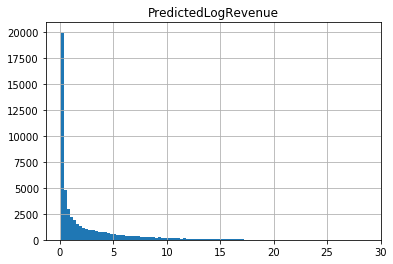

In [77]:
%matplotlib inline
subm[subm['PredictedLogRevenue'] >= 0.1].hist(bins=100)

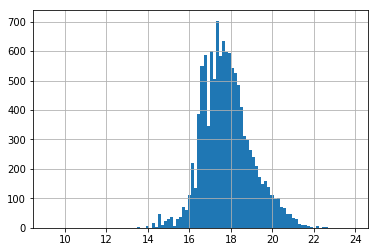

In [78]:
%matplotlib inline
full_df.fillna(0)[full_df['transactionRevenue'].fillna(0) >= 0.1]['transactionRevenue'].hist(bins=100)